## 라이브러리 불러오기

In [1]:
# API 호출
# ## https://data.go.kr/tcs/dss/selectApiDataDetailView.do?publicDataPk=15057440
from urllib.request import Request, urlopen
# Request https://docs.python.org/ko/3/library/urllib.request.html#urllib.request.Request
# urlopen https://docs.python.org/ko/3/library/urllib.request.html#urllib.request.urlopen
from urllib.parse import urlencode, quote_plus
# urlenocde https://docs.python.org/ko/3/library/urllib.parse.html#urllib.parse.urlencode
# quote_plus https://docs.python.org/ko/3/library/urllib.parse.html#urllib.parse.quote_plus
from urllib.parse import unquote
import requests

# 시간 생성
import time
import datetime
from pytz import timezone, utc

# 폴더 자동 생성
import os

# 코드 스케줄링
import threading
# import schedule

# XML 파싱
import xml.etree.ElementTree as ET

# 입력데이터 데이터프레임 작성
import pandas as pd
import numpy as np

# DataFrame 화면 출력                                                # DataFrame 화면 출력 설정이 변경되어 있습니다 #
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = None # default = 60

#EXCEL
import openpyxl

# 배차간격 확인 scatter plot 출력
import matplotlib.pyplot as plt

# nan 값 생성
from math import isnan

In [2]:
# 폴더 자동 생성 함수
# https://data-make.tistory.com/170
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

## 기본값 설정하기

In [3]:
def todayStr(year:int, month:int, day:int) -> str:
    todayDateTimeStr = f"{year}-{month}-{day}"
    return todayDateTimeStr

In [4]:
def makeRangeIndex(station_df):
    return station_df.index

### 노선ID(routeId)별 정류소정보 DataFrame

In [5]:
routeId = 204000046
year = 2020
month = 12
day = 30

In [6]:
df1 = pd.DataFrame()

In [7]:
dfList = [df1]
dayList = [28]

In [8]:
todayDateTimeStr = todayStr(year, month, day)
outputFileName = todayDateTimeStr + '.csv'
stationFileName = 'station_df.csv'

In [9]:
outputFolderPath = os.getcwd() + '/out/' + str(routeId) + '/r1/'
outputFilePath = outputFolderPath + outputFileName
stationFilePath = outputFolderPath + stationFileName

### csv파일에 저장된 데이터를 datetime 형식으로 변환하여 데이터프레임에 저장

In [10]:
'''
to_datetime Value Error: at least that [year, month, day] must be specified Pandas
https://stackoverflow.com/questions/39992411/to-datetime-value-error-at-least-that-year-month-day-must-be-specified-pand/39992541#39992541
'''
def dailytimetable(year, month, day):
    todayDateTimeStr = todayStr(year, month, day)
    outputFileName = todayDateTimeStr + '.csv'
    outputFolderPath = os.getcwd() + '/out/' + str(routeId) + '/r1/'
    outputFilePath = outputFolderPath + outputFileName

    df = pd.read_csv(outputFilePath, parse_dates=True)

    /print outputFilePath '\n'
    df = pd.to_datetime(df.stack(), format='%Y-%m-%d %H:%M:%S').unstack()
    oldColumns = df.columns
    # df.dtypes
    return df

In [11]:
# dailytimetable(year=2020, month=12, day=27)

## dataframe의 dtypes를 total_seconds로 변환한다

In [12]:
def seconds_df(year, month, day):
    df = dailytimetable(year, month, day)
    todayDateTimeStr = todayStr(year, month, day)

    sampleTime = np.datetime64(todayDateTimeStr)

    timedeltaDf = df - sampleTime

    totalSecondsDf = timedeltaDf.stack().dt.total_seconds().unstack()

    oldColumns = totalSecondsDf.columns
    newColumns = range(1, len(oldColumns)+1)
    totalSecondsDf.columns = newColumns
    
    #오류데이터 제거
    boolDf = totalSecondsDf.diff() < 0
    totalSecondsDf[boolDf] = float('nan')

    return totalSecondsDf

In [13]:
sdf = seconds_df(2020, 12, 30)
np.argmin(sdf.isnull().sum(axis=0))

/home/ubuntu/Data-Structure-Project/out/204000046/r1/2020-12-30.csv 



9

## 노선ID의 정류소 데이터를 데이터프레임에 저장

In [14]:
station_df = pd.read_csv(stationFilePath)

In [15]:
maxIndex = len(sdf.index)
dist = station_df['accumDistance'].iloc[:maxIndex]

### 배차별 정류소 도착 시간을 scatter plot으로 그려보자

In [16]:
if False:
    plt.figure(figsize=(20, 20))
    plt.xlabel("distance")
    plt.ylabel("time")
    for i in range(1):#sdf.columns:
        # null index를 찾아서 distance series에서 데이터를 제외한다
        _series = sdf.iloc[i]
        _boolSeries = _series.isnull()
        boolSeries = np.invert(_boolSeries)
        dropSeries = _series[boolSeries]
        dropDist = sdf.columns[boolSeries]
        if( True ):
            plt.scatter(dropDist, dropSeries)
            plt.plot(dropDist, dropSeries)
    plt.show()

## 차이가 일정한가?

### 배차에 따른 정류소간 이동시간의 편차는 일정한가?

In [17]:
index = 3

In [18]:
colDiff = sdf.iloc[index] - sdf.iloc[index-1]
display(pd.DataFrame(colDiff).transpose())
print("null\t",colDiff.isnull().sum())
colDiff.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74
0,59.0,NaN,59.0,60.0,60.0,60.0,60.0,60.0,119.0,59.0,60.0,59.0,118.0,60.0,60.0,60.0,60.0,60.0,59.0,NaN,NaN,59.0,60.0,59.0,59.0,59.0,59.0,NaN,NaN,59.0,60.0,59.0,NaN,60.0,60.0,59.0,59.0,59.0,60.0,60.0,60.0,NaN,NaN,NaN,60.0,59.0,60.0,59.0,60.0,60.0,59.0,59.0,60.0,NaN,60.0,60.0,60.0,60.0,NaN,60.0,NaN,60.0,59.0,60.0,59.0,60.0,59.0,59.0,60.0,60.0,60.0,59.0,60.0,60.0


null	 12


count     62.000000
mean      61.500000
std       10.503317
min       59.000000
25%       59.000000
50%       60.000000
75%       60.000000
max      119.000000
dtype: float64

In [19]:
colCate = pd.cut(colDiff, 2)
colDiff.groupby(colCate).agg(['count', 'mean', 'std', 'min', 'max'])

,count,mean,std,min,max
"(58.94, 89.0]",60,59.6,0.494032,59.0,60.0
"(89.0, 119.0]",2,118.5,0.707107,118.0,119.0


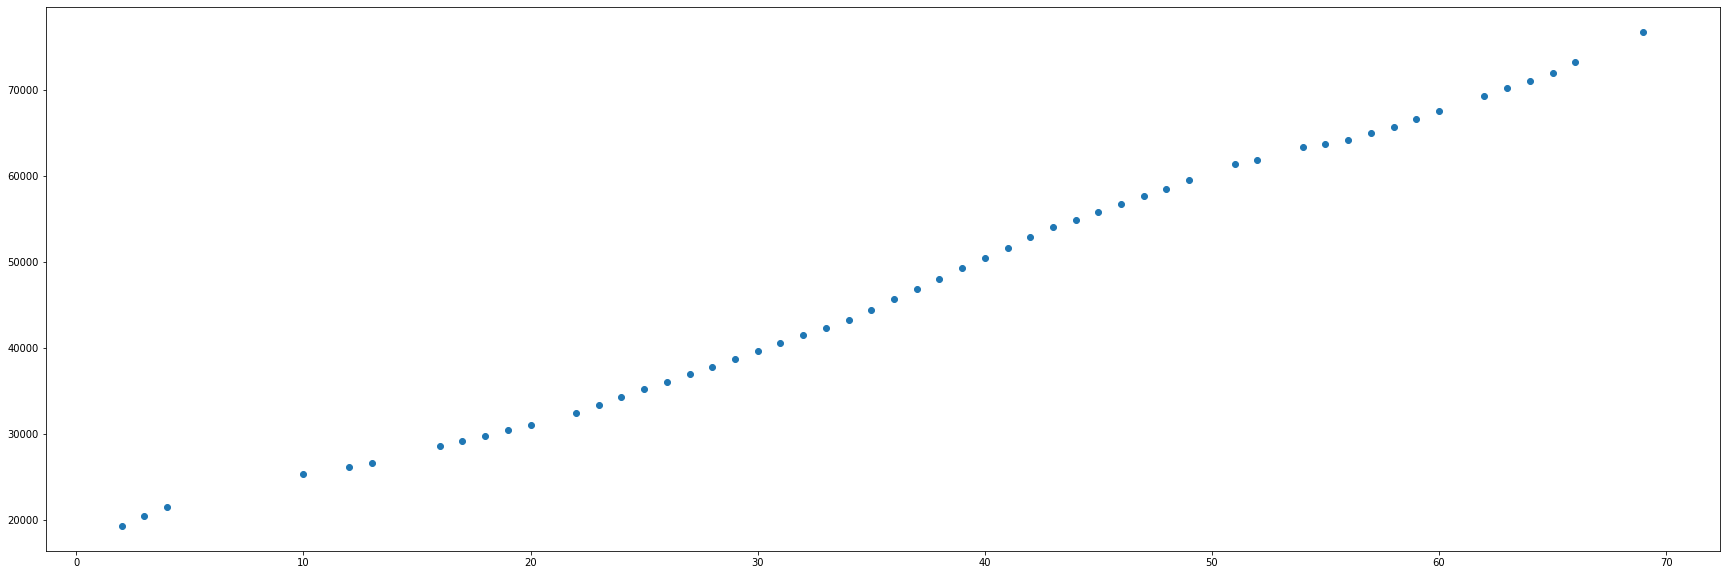

In [20]:
index = 0

_Arr = sdf.iloc[index]
# _Arr = sdf.iloc[:,index]
Arr = _Arr.dropna()

_boolArr = _Arr.isnull()
boolArr = np.invert(_boolArr)

# distArr = dist[boolArr]
indexArr = _Arr.index[boolArr]

plt.figure(figsize=(30, 10))
plt.scatter(indexArr, Arr)
# plt.scatter(distArr, Arr)
plt.show()

In [21]:
colDiff2 = sdf.iloc[index] + sdf.iloc[index-2]
colDiff2 /= 2
colDiff2 -= sdf.iloc[index-1]
display(pd.DataFrame(colDiff2).transpose())
print("null\t",colDiff2.isnull().sum())
colDiff2.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3699.0,NaN,NaN,NaN,NaN,NaN,-3578.5,-3549.0,NaN,NaN,-3249.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


null	 70


count       4.000000
mean    -3519.000000
std       191.023995
min     -3699.000000
25%     -3608.625000
50%     -3563.750000
75%     -3474.125000
max     -3249.500000
dtype: float64

In [22]:
colCate2 = pd.cut(colDiff2, 3)
colDiff2.groupby(colCate2).agg(['count', 'mean', 'std', 'min', 'max'])

,count,mean,std,min,max
"(-3699.45, -3549.167]",2,-3638.75,85.206367,-3699.0,-3578.5
"(-3549.167, -3399.333]",1,-3549.00,NaN,-3549.0,-3549.0
"(-3399.333, -3249.5]",1,-3249.50,NaN,-3249.5,-3249.5


### 배차간격

In [23]:
rowDiff = sdf.iloc[index].diff() - sdf.iloc[index+1].diff()
display(pd.DataFrame(rowDiff).transpose())
print("null\t",rowDiff.isnull().sum())
rowDiff.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74
0,NaN,NaN,1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,59.0,0.0,0.0,1.0,NaN,NaN,NaN,0.0,-1.0,0.0,0.0,-1.0,2.0,0.0,0.0,-60.0,59.0,0.0,0.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,0.0,1.0,-1.0,1.0,-1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


null	 44


count    30.000000
mean      2.033333
std      18.987261
min     -60.000000
25%       0.000000
50%       0.000000
75%       1.000000
max      59.000000
dtype: float64

In [24]:
rowCate = pd.cut(rowDiff, 3)
rowDiff.groupby(rowCate).agg(['count', 'mean', 'std', 'min', 'max'])

,count,mean,std,min,max
"(-60.119, -20.333]",1,-60.000000,NaN,-60.0,-60.0
"(-20.333, 19.333]",27,0.111111,0.800641,-1.0,2.0
"(19.333, 59.0]",2,59.000000,0.000000,59.0,59.0


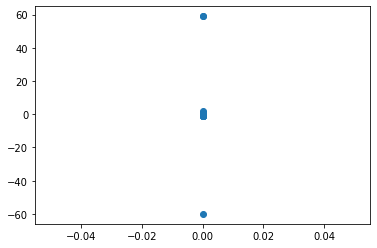

In [25]:
elemCount = len(rowDiff.dropna())
plt.scatter(np.ones(elemCount) * index, rowDiff.dropna())
plt.show()

### 다른 날짜의 일일시간표로 결측치를 채운다

In [39]:
routeId = 204000046
s26 = seconds_df(2020, month=12, day=26)
s27 = seconds_df(2020, month=12, day=27)
s28 = seconds_df(2020, month=12, day=28)
s29 = seconds_df(2020, month=12, day=29)
s30 = seconds_df(2020, month=12, day=30)
s31 = seconds_df(2020, month=12, day=31)
dfList = [s28, s29, s30, s31]
wdfList = [s26, s27]

/home/ubuntu/Data-Structure-Project/out/204000046/r1/2020-12-26.csv 

/home/ubuntu/Data-Structure-Project/out/204000046/r1/2020-12-27.csv 

/home/ubuntu/Data-Structure-Project/out/204000046/r1/2020-12-28.csv 

/home/ubuntu/Data-Structure-Project/out/204000046/r1/2020-12-29.csv 

/home/ubuntu/Data-Structure-Project/out/204000046/r1/2020-12-30.csv 

/home/ubuntu/Data-Structure-Project/out/204000046/r1/2020-12-31.csv 



### 일일시간표가 여러개 있는 경우

In [27]:
append_df = pd.DataFrame(columns=s28.columns, index=[0, 1, 2, 3])

index = 1
append_df.iloc[0] = s28.iloc[index]
append_df.iloc[1] = s29.iloc[index]
append_df.iloc[2] = s30.iloc[index]
append_df.iloc[3] = s31.iloc[index]

display((pd.DataFrame(append_df.median()).transpose()))

/home/ubuntu/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74
0,18118.0,19309.0,20507.0,21529.0,22311.0,22906.5,23532.5,24114.0,24701.0,25328.0,25900.5,26242.5,26665.0,27537.5,28027.0,28607.0,29201.5,29824.0,30419.5,31030.0,31737.0,32536.0,33426.0,34342.5,35222.0,36153.0,37031.0,37939.0,38832.0,39726.0,40626.0,41523.5,42408.0,43301.0,44502.0,45721.5,46937.0,48128.5,49325.0,50516.0,51705.0,52951.0,54147.0,55043.0,55937.5,56831.0,57727.0,58621.0,59512.5,60381.5,61362.0,61927.0,62548.5,63155.0,63812.0,64342.0,65061.5,65835.5,66727.0,67631.0,NaN,69748.0,70909.0,71865.0,72153.0,73297.0,74541.0,75704.5,76924.0,78092.5,79341.0,80808.0,82299.0,83493.0


In [28]:
median = append_df.median()/60#.fillna(-3600)/60
median.interpolate(inplace=True)

/home/ubuntu/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [34]:
hour = (median/60).astype('int32')
hour_str = hour.apply(lambda x: "{:0>2d}".format(x)).astype('str')
minute = (median - hour*60).astype('int32')
minute_str = minute.apply(lambda x: "{:0>2d}".format(x)).astype('str')

In [35]:
tdf = pd.Series(hour_str + ':' + minute_str)

In [36]:
hour_df = pd.DataFrame(hour,columns=['hour'])
newIndex = hour_df.groupby(['hour']).size().index

In [37]:
_df = pd.DataFrame(index = newIndex, columns=range(10))
for i, index in enumerate(hour_df.groupby(['hour']).size().index):
#     if(index<0): continue
    _df.iloc[i] = tdf[hour == index].reset_index(drop=True)
_df.dropna(how='all', axis=1, inplace=True)
busCount = np.invert(_df.isnull()).sum().sum()
_df.fillna(' ', inplace=True)

In [40]:
# print(_df.to_html())

### 일일시간표가 하나만 있는 경우

In [55]:
for i in range(5):
    nullCnt = s26.iloc[i].isnull().sum()
    print(f"index {i}: {nullCnt:2d}")

index 0: 11
index 1:  8
index 2:  5
index 3:  1
index 4:  4


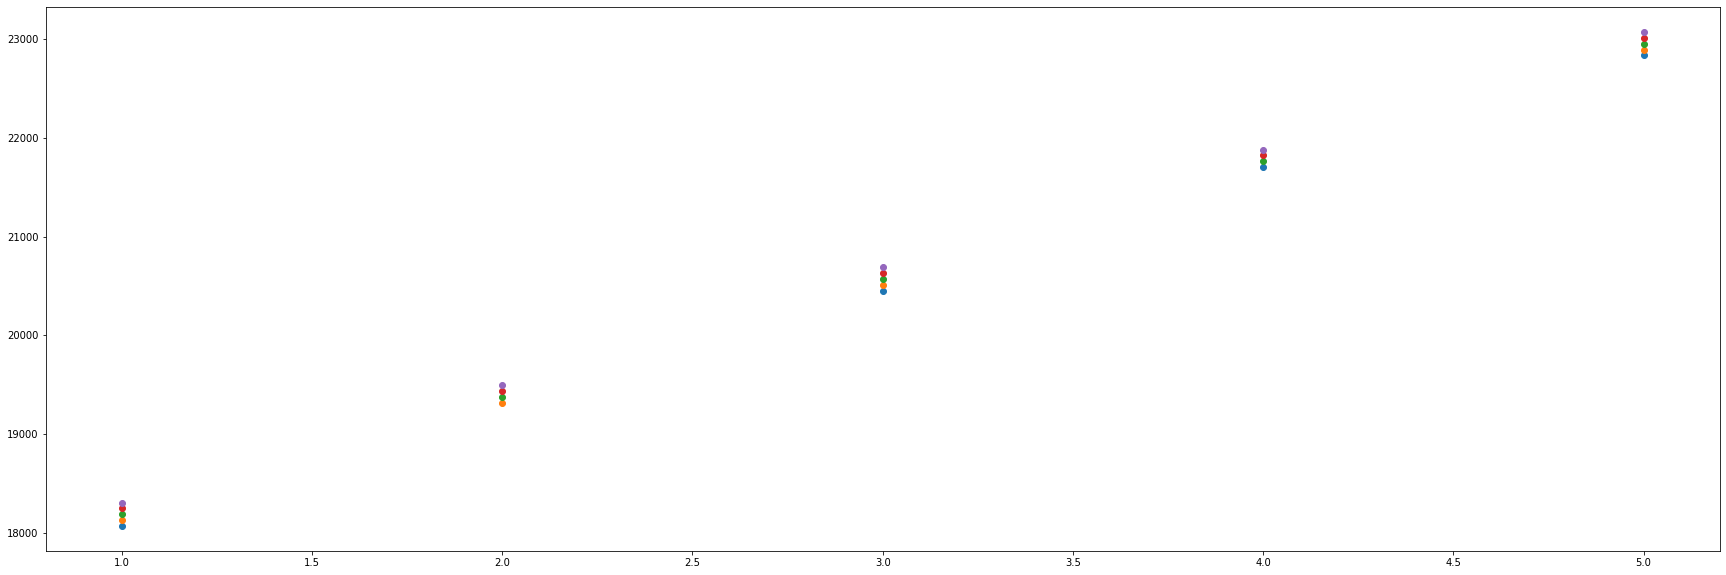

In [70]:
plt.figure(figsize=(30, 10))
_df = s26.loc[:4, :5]
_index = _df.index
for i in _index:
    _null_df = _df.iloc[i]
    _bool = np.invert(_null_df.isnull())
    df = _null_df[_bool]
    _x = df.index
    plt.scatter(_x, df)

In [71]:
_df

,1,2,3,4,5
0,18067.0,NaN,20452.0,21704.0,22836.0
1,18126.0,19319.0,20512.0,NaN,22896.0
2,18186.0,19378.0,20571.0,21764.0,22956.0
3,18246.0,19438.0,20631.0,21823.0,23016.0
4,18306.0,19497.0,20691.0,21883.0,23075.0


## 일일시간표의 index번째 행을 출력한다

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74
0,300,321,-999,357,371,-999,391,401,-999,421,-999,-999,443,458,-999,-999,-999,-999,505,516,528,541,555,571,-999,601,616,631,646,661,676,690,705,721,740,761,781,801,-999,-999,-999,880,901,-999,931,946,-999,977,990,1006,1021,1030,1041,1050,-999,1072,1083,1096,1111,1127,1140,1156,1171,1185,1201,-999,-999,1261,1281,-999,-999,-999,-999,1391


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74
0,301,-999,-999,358,-999,381,391,-999,411,-999,-999,436,442,458,-999,-999,-999,-999,-999,516,527,541,555,570,586,600,-999,631,645,660,675,691,706,721,-999,-999,780,801,820,841,-999,881,-999,-999,930,946,960,975,990,1006,1020,1031,1040,-999,1061,1071,1083,-999,-999,1125,1140,1155,1170,1186,1201,-999,1241,1261,1281,-999,-999,-999,1371,-999


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74
0,-999,321,340,357,-999,-999,-999,-999,-999,421,-999,436,443,-999,-999,475,485,496,506,516,-999,541,556,570,586,601,616,630,646,661,676,690,705,720,740,761,781,801,821,840,860,881,901,915,931,946,961,976,991,-999,1023,1031,-999,1057,1062,1070,1083,1096,1111,1126,-999,1156,1171,1185,1200,1221,-999,-999,1280,-999,-999,-999,-999,-999


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74
0,-999,-999,-999,359,-999,380,390,400,410,421,-999,436,443,-999,-999,476,-999,495,505,-999,527,541,556,571,-999,601,615,-999,646,661,676,-999,-999,-999,740,-999,781,801,-999,725,-999,881,902,915,800,-999,961,976,991,1005,1020,1030,1041,1051,-999,1071,-999,1096,1118,1135,1150,1166,1180,1196,1208,-999,1242,1260,1281,1301,1321,1345,1370,1391


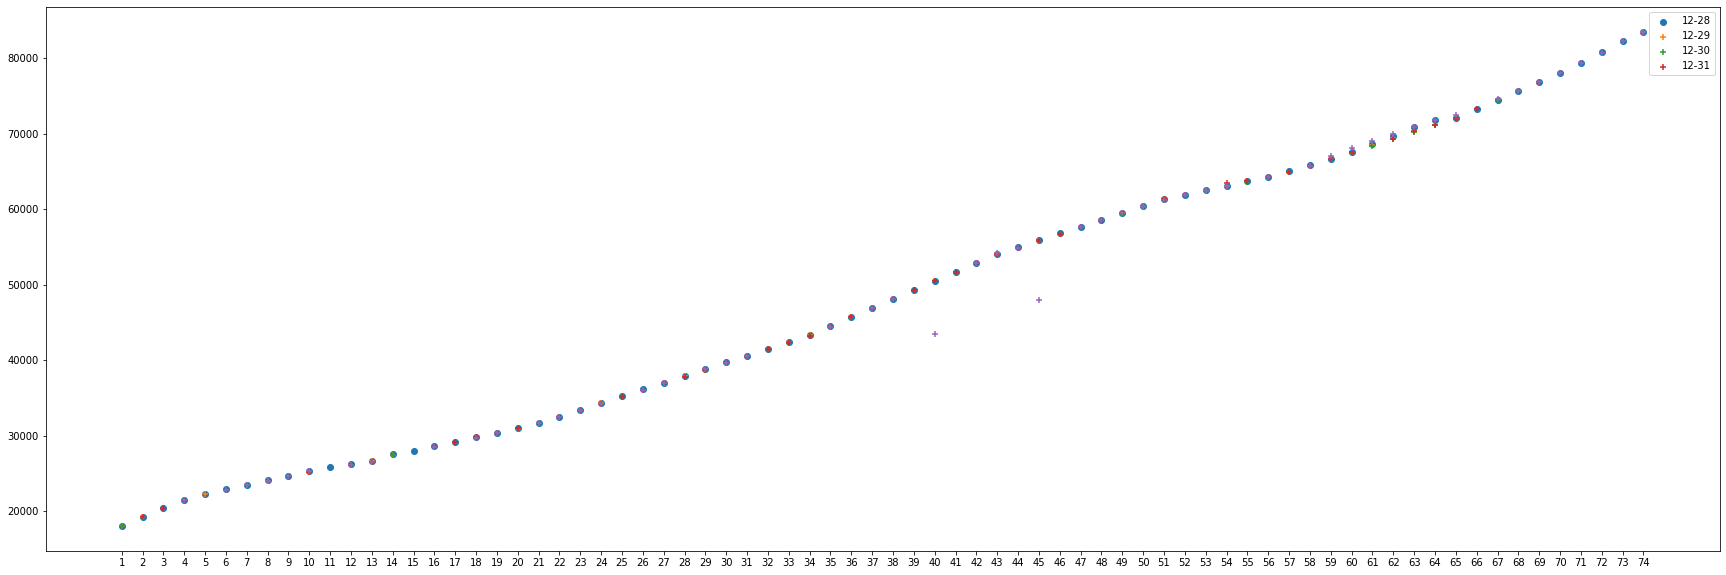

In [276]:
index = 1

plt.figure(figsize=(30, 10))
plt.scatter(append_df.columns, median*60)

for _df in dfList:
    index = 0

    _Arr = _df.iloc[index]
    display(pd.DataFrame((_Arr.fillna(-59940)/60).astype('int32')).transpose())
    Arr = _Arr.dropna()

    _boolArr = _Arr.isnull()
    boolArr = np.invert(_boolArr)

    indexArr = _Arr.index[boolArr]

    plt.scatter(indexArr, Arr, marker='+')

plt.legend(["12-28", "12-29", "12-30", "12-31"])
plt.xticks(_df.columns)
plt.show()

## 앞차와 뒷차의 운행기록을 기준으로 결측치를 채운다.

In [14]:
'''
01. 데이터프레임의 행 하나(시리즈)를 가져온다.
    ISSUE: 행(버스 한대의 데이터)과 열(정류장 한개의 데이터)중 어떤 데이터를 사용할것인가?
           기준은 무엇인가?
02. 시리즈의 각 데이터에서 기준시간을 빼서 timedelta 타입으로 변환한다.
    메소드 'interpolate'를 호출하기 위해선 데이터 타입이 'timedelta'여야 한다. 
03. Series.interpolate()를 호출하여 결측치를 채운다.
04. timedelta 타입 데이터를 datetime 타입으로 형 변환한다.
05. 시리즈를 반환한다. 함수 종료.
'''
isShowInfo = False

In [15]:
# 1.
index=1
datetimeArr = sdf.iloc[index]
# datetimeArr = df['경기70아8880_0']

In [16]:
### 데이터 확인
if (isShowInfo):
    # Count NaT
    beforeNullCnt = timedeltaSeries.isnull().sum()
    print(f"결측치 처리 이전 NaT Cnt:{beforeNullCnt:3d}개")
    
    # Display numpy array dataframe style
    tempDfTDS = pd.DataFrame(datetimeArr).transpose()
    newColumns = range(1, len(timedeltaSeries)+1)
    tempDfTDS.columns = newColumns
    display(tempDfTDS)
    
    _temp_Series = totalSecondsSeries.reset_index(drop=True)
    _x = _temp_Series.index[0:]
    _y = _temp_Series.values[0:]
    plt.plot(_x, _y)
    plt.show()

In [17]:
def errorCheck(index, sdf):
    # 1.
    totalSecondsSeries = sdf.iloc[index]
    # datetimeArr = df['경기70아8880_0']

    # 2. 시리즈(np.array)에서 기준시간을 뺀다. 데이터 타입이 timedelta로 바뀐다.
    #sampleTime = np.datetime64(todayDateTimeStr)
    #timedeltaArr = datetimeArr - sampleTime
    #timedeltaSeries = pd.Series(timedeltaArr)
    #totalSecondsSeries = timedeltaSeries.dt.total_seconds()

    # 3. 오류데이터:시간의 역전 을 찾는다 (preTime>nextTime)
    preTime = 0
    for i, second in enumerate(totalSecondsSeries):
        if(isnan(second)):
            #/print 'nan'
            continue
        nextTime = second
        #/print preTime nextTime
        if(preTime>nextTime):
            /print f'\n{i} ########BeepBeep\n'
            totalSecondsSeries[i] = float('NaN')
            continue

        preTime = nextTime

    # 4. timedelta를 datetime으로 변환
    #newDatetimeSeries = pd.to_datetime(totalSecondsSeries, unit='s')
    #newDatetimeSeries = newDatetimeSeries.dt.strftime('%Y-%m-%d %H:%M:%S')

    # 5. df 수정
    df.iloc[index] = totalSecondsSeries

In [18]:
for i in range(5):
    errorCheck(i, sdf)

In [19]:
# *데이터 확인
if (isShowInfo):
    # Count NaT
    beforeNullCnt = newTimedeltaSeries.isnull().sum()
    print(f"결측치 처리 이전 NaT Cnt:{beforeNullCnt:3d}개")
    
    # Display numpy array dataframe style
    tempDfTDS = pd.DataFrame(newDatetimeSeries).transpose()
    display(tempDfTDS)
    
    _temp_Series = totalSecondsSeries.reset_index(drop=True)
    _x = _temp_Series.index[0:]
    _y = _temp_Series.values[0:]
    plt.plot(_x, _y)
    plt.show()

In [48]:
/print sdf.iloc[1].isnull().sum()
pd.DataFrame(sdf.iloc[1]).transpose()

20


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74
1,18118.0,NaN,20498.0,21512.0,22347.0,22883.0,23539.0,24135.0,24673.0,25328.0,NaN,NaN,26696.0,27589.0,NaN,28599.0,29194.0,NaN,30383.0,31037.0,31752.0,32524.0,33415.0,34365.0,NaN,36153.0,37044.0,37939.0,38832.0,39726.0,40623.0,41514.0,42408.0,NaN,44492.0,45743.0,46934.0,48124.0,49376.0,50449.0,NaN,52892.0,54143.0,55040.0,55936.0,56831.0,57725.0,NaN,NaN,NaN,61362.0,61897.0,62552.0,63148.0,NaN,64399.0,65057.0,65833.0,66727.0,NaN,NaN,NaN,NaN,NaN,72153.0,NaN,74480.0,75733.0,76926.0,78061.0,NaN,80806.0,NaN,83548.0


In [49]:
/print sdf.iloc[1].interpolate(limit_area='inside').isnull().sum()
pd.DataFrame(sdf.iloc[1].interpolate(limit_area='inside')).transpose()

0


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74
1,18118.0,19308.0,20498.0,21512.0,22347.0,22883.0,23539.0,24135.0,24673.0,25328.0,25784.0,26240.0,26696.0,27589.0,28094.0,28599.0,29194.0,29788.5,30383.0,31037.0,31752.0,32524.0,33415.0,34365.0,35259.0,36153.0,37044.0,37939.0,38832.0,39726.0,40623.0,41514.0,42408.0,43450.0,44492.0,45743.0,46934.0,48124.0,49376.0,50449.0,51670.5,52892.0,54143.0,55040.0,55936.0,56831.0,57725.0,58634.25,59543.5,60452.75,61362.0,61897.0,62552.0,63148.0,63773.5,64399.0,65057.0,65833.0,66727.0,67631.333333,68535.666667,69440.0,70344.333333,71248.666667,72153.0,73316.5,74480.0,75733.0,76926.0,78061.0,79433.5,80806.0,82177.0,83548.0


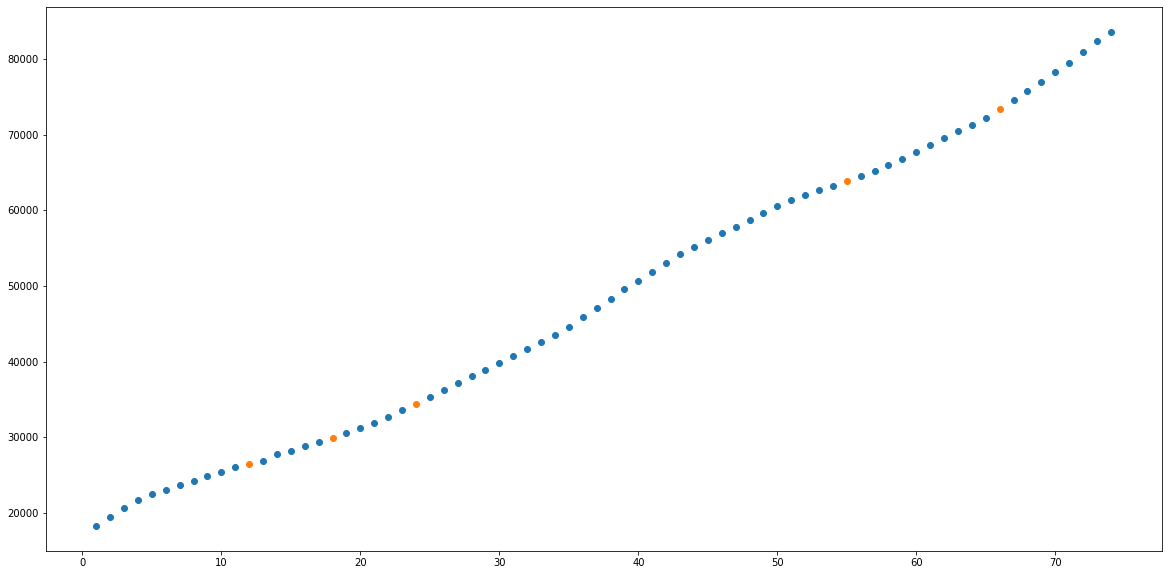

In [64]:
index = 3
plt.figure(figsize=(20, 10))
plt.scatter(sdf.columns, sdf.iloc[index])
plt.scatter(sdf.columns[(sdf.iloc[index].isnull())], sdf.iloc[index].interpolate(limit_area='inside')[(sdf.iloc[index].isnull())])
plt.show()

## 배차간격을 확인하고 오류데이터를 NaN으로 변환한다.

In [28]:
'''
앞차와 뒷차의 배차간격을 저장하는 리스트를 반환한다. 
01. 첫번째 데이터를 예외처리한다. 
    배차간격의 수는 배차수 - 1 이므로 첫번째 데이터를 0으로 하거나 첫차시간을 기록한다.
02. 앞차(prevData) 또는 뒷차(nextData)가 NaT일때 예외처리 한다.
    next
03. 오류데이터(운행 기록 시간이 작아짐)를 예외처리 한다.
'''
prevData = 0
intervalList = []
i = 0

for nextData in totalSecondsSeries:
    i += 1
    interval = -9999
    if(prevData):
        interval = nextData - prevData
        if(interval<0):
            '''
            오류데이터를 시리즈 데이터에서 NaT로 초기화하는 과정이 필요하다.
            함수로 사용한다면 시리즈 데이터의 값이 바뀔수 있도록 접근해야 한다.
            '''
            /print "오류데이터 처리"
            newTimedeltaSeries.iloc[i] = float('NaN')
            interval = float('NaN')
            intervalList.append(interval)
            prevData = 0
            continue
        interval /= 60
        intervalList.append(interval)
    else:
        interval = float('NaN')
        intervalList.append(interval)
#     print(f"{i:3d}\tPREV: {prevData:10.0f}\tNEXT: {nextData:10.0f}\tINTERVAL: {interval:7.1f}")
    
    prevData = nextData

intervalList = np.round(intervalList, 0)
print(f"INT LIST의 데이터 수:{len(intervalList):3d}\n", intervalList)

INT LIST의 데이터 수: 74
 [nan nan 20. nan nan 10. 18.  5. nan nan  8.  7.  7. 15.  8. 12.  8. 10.
 10. 10. 13. 13. 15. 15. 15. 16. 14. 15. nan nan nan 15. 15. 15. 20. 21.
 20. 20. 20. 20. 20. 20. 20. 18. 13. 15. 15. 17. 13. 15. 15. 11. nan nan
 11.  9. 13. nan nan 15. 15. 15. 15. 15. 15. 20. 23. 18. nan nan 20. nan
 nan 23.]


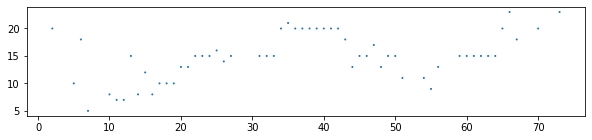

In [29]:
plt.figure(figsize=(10, 2))
plt.scatter(np.arange(len(intervalList)), intervalList, s=intervalList>0)
plt.show()

### 출차 시간을 그래프에 찍어본다.

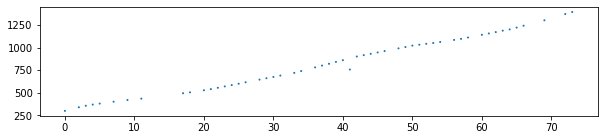

In [77]:
'''
01. 데이터프레임의 행 하나(시리즈)를 가져온다.
02. 시리즈의 각 데이터에서 기준시간, 조사일의 자정(00시)),을 빼서 timedelta 타입으로 변환한다.
'''
isShowInfo = True

# 1.
datetimeArr = df.iloc[0]

# 2. 시리즈(np.array)에서 기준시간을 뺀다. 데이터 타입이 timedelta로 바뀐다.
sampleTime = np.datetime64(todayDateTimeStr)
timedeltaArr = datetimeArr - sampleTime
timedeltaSeries = pd.Series(timedeltaArr)
totalSecondsSeries = timedeltaSeries.dt.total_seconds()
totalSecondsSeries /= 60
totalSecondsSeries

plt.figure(figsize=(10, 2))
plt.scatter(np.arange(len(totalSecondsSeries)), totalSecondsSeries, s=totalSecondsSeries>0)
plt.show()

In [31]:
sampleTime

numpy.datetime64('2020-12-23')

In [ ]:
'''
01. 데이터프레임의 행 하나(시리즈)를 가져온다.
02. 시리즈의 각 데이터에서 기준시간, 조사일의 자정(00시)),을 빼서 timedelta 타입으로 변환한다.
'''
plt.figure(figsize=(20, 5))

for i in range(1):
    # 1.
    datetimeArr = oneDay_df.iloc[i]

    # 2. 시리즈(np.array)에서 기준시간을 뺀다. 데이터 타입이 timedelta로 바뀐다.
    sampleTime = np.datetime64(todayDateTimeStr)
    timedeltaArr = datetimeArr - sampleTime
    timedeltaSeries = pd.Series(timedeltaArr)
    totalSecondsSeries = timedeltaSeries.dt.total_seconds()
    totalSecondsSeries /= 60
    totalSecondsSeries

    plt.scatter(np.arange(len(totalSecondsSeries)), totalSecondsSeries, s=totalSecondsSeries>0)
plt.show()

In [ ]:
hours = newTimedeltaSeries//3600
minutes = round(newTimedeltaSeries/60 - (hours)*60)
for h, m in zip(hours, minutes):
    try:
        print(int(h), int(m), sep=':')
    except:
        print('nan')

In [ ]:
newDatetimeSeries = pd.to_datetime(newTimedeltaSeries, unit='s')
newDatetimeSeries = newDatetimeSeries.dt.strftime('%Y-%m-%d %H:%M:%S')
pd.DataFrame(newDatetimeSeries).transpose()

### curve-fit을 이용하여 외삽(extrapolation) 실행

In [ ]:
#데이터 확인
datetimeArr = oneDay_df.iloc[1]

# 2. 시리즈(np.array)에서 기준시간을 뺀다. 데이터 타입이 timedelta로 바뀐다.
sampleTime = np.datetime64(todayDateTimeStr)
timedeltaArr = datetimeArr - sampleTime
timedeltaSeries = pd.Series(timedeltaArr)
totalSecondsSeries = timedeltaSeries.dt.total_seconds()
totalSecondsSeries /= 60
pd.DataFrame(totalSecondsSeries).transpose()

# plt.scatter(np.arange(len(totalSecondsSeries)), totalSecondsSeries, s=totalSecondsSeries>0)

In [ ]:
busCount = len(totalSecondsSeries)
newIndex = np.arange(busCount)

In [ ]:
_dropSeries = totalSecondsSeries.reset_index(drop=True).dropna()
_x = _dropSeries.index[:5]
_y = _dropSeries.values[:5]

In [ ]:
# y=ax^2+bx+c를 리턴합니다.
def func(x, a, b, c):
    return a*(x**2) + b*x + c

In [ ]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(func, _x, _y)

In [ ]:
plt.plot(range(-1, 6), [func(i, *popt) for i in range(-1, 6)])
plt.scatter(range(-1, 6), [func(i, *popt) for i in range(-1, 6)])
plt.scatter(_x, _y)
plt.legend(['asti-func', 'asti-time', 'real-time'])
plt.show()